# Part 1: Anomaly detection

## a)

In [3]:
# Preprocessing the GenSyn2122 dataset
import os
import pandas as pd
import numpy as np

# Define filenames
DATA_FILE = "GenSyn2122.csv"
LABEL_FILE = "GenSyn_labels2122.csv"

# Check and load if files exist
if os.path.exists(DATA_FILE) and os.path.exists(LABEL_FILE):
    print("Loading GenSyn2122 dataset...")
    df = pd.read_csv(DATA_FILE)
    y_labels = pd.read_csv(LABEL_FILE)['anomaly_label'].values

    # Preprocessing steps
    # One-hot encode 'season' (convert to 0/1)
    df = pd.get_dummies(df, columns=['season'], drop_first=True, dtype=int)

    # Add cyclical transformation for day_of_year
    df['day_of_year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
    df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)

    # Drop original day_of_year column
    df = df.drop(columns=['day_of_year'])

    # Display first few rows to check result
    display(df)
else:
    print("Error: One or both files are missing. Please check GenSyn2122.csv and GenSyn_labels2122.csv are in the working directory.")


Loading GenSyn2122 dataset...


,year,temperature,humidity,energy_usage,season_spring,season_summer,season_winter,day_of_year_sin,day_of_year_cos
0,2021,19.708638,78.625889,11.731837,0,1,0,1.721336e-02,0.999852
1,2021,20.703554,78.350411,13.453957,0,1,0,3.442161e-02,0.999407
2,2021,21.339178,82.736788,15.393096,0,1,0,5.161967e-02,0.998667
3,2021,20.823304,79.921728,16.657684,0,1,0,6.880243e-02,0.997630
4,2021,22.277698,80.406175,16.927320,0,1,0,8.596480e-02,0.996298
...,...,...,...,...,...,...,...,...,...
725,2022,24.648768,79.422802,18.579817,0,1,0,-6.880243e-02,0.997630
726,2022,24.362897,80.541095,19.394421,0,1,0,-5.161967e-02,0.998667
727,2022,24.730546,85.748327,20.060006,0,1,0,-3.442161e-02,0.999407
728,2022,26.975549,81.506959,20.840548,0,1,0,-1.721336e-02,0.999852


## b)

In [4]:
from sklearn.ensemble import IsolationForest 
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import precision_score, recall_score

# Isolation Forest
if_model = IsolationForest(random_state=42)
if_preds = if_model.fit_predict(df)

# Local Outlier Factor
lof_model = LocalOutlierFactor()
lof_preds = lof_model.fit_predict(df)

# Convert true labels and predictions to binary: 1 = anomaly, 0 = normal
y_true = (y_labels == -1).astype(int)
if_pred_binary = (if_preds == -1).astype(int)
lof_pred_binary = (lof_preds == -1).astype(int)

# Calculate precision and recall
if_recall = recall_score(y_true, if_pred_binary)
if_precision = precision_score(y_true, if_pred_binary)
lof_recall = recall_score(y_true, lof_pred_binary)
lof_precision = precision_score(y_true, lof_pred_binary)

# Print results
print(f"Isolation Forest → Recall: {if_recall:.3f}, Precision: {if_precision:.3f}")
print(f"LOF → Recall: {lof_recall:.3f}, Precision: {lof_precision:.3f}")

Isolation Forest → Recall: 0.944, Precision: 0.047
LOF → Recall: 0.444, Precision: 0.276


Isolation Forest achieved high recall (0.944) but low precision (0.047), meaning it detected almost all anomalies but with many false positives. LOF had lower recall (0.444) but higher precision (0.276), making it stricter but more accurate when flagging anomalies. This suggests IF is better when missing anomalies is very costly, such as fraud or security monitoring, while LOF is preferable when false alarms are expensive or disruptive, such as in industrial or healthcare settings.


## c)

For hyperparameter tuning, I selected contamination values of 0.03 and 0.1 because:
--0.1 is the typical default in both Isolation Forest and LOF, assuming ~10% of the data are anomalies.
--0.03 tests a stricter setting, reducing assumed anomalies to improve precision and reduce false positives.

For Isolation Forest, I tested n_estimators values of 100, 200, and 300:
--100 is the sklearn default.
--200 and 300 increase the number of trees, improving ensemble robustness and averaging without adding too much computational cost.

For Local Outlier Factor, I tested n_neighbors values of 10, 20, and 50:
--10 looks at very small local neighborhoods (fine detail).
--20 balances local and wider patterns.
--50 smooths local noise and focuses on broader anomaly patterns.

These choices balance meaningful parameter exploration without creating too many combinations to interpret clearly

In [5]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import precision_score, recall_score

# Parameters
contamination_values = [0.03, 0.1]
if_estimators = [100, 200, 300]
lof_neighbors = [10, 20, 50]

# Store results
results_if = []
results_lof = []

# Isolation Forest tuning
for cont in contamination_values:
    for n_est in if_estimators:
        if_model = IsolationForest(contamination=cont, n_estimators=n_est, random_state=42)
        preds = if_model.fit_predict(df)
        preds_bin = (preds == -1).astype(int)
        recall = recall_score((y_labels == -1).astype(int), preds_bin)
        precision = precision_score((y_labels == -1).astype(int), preds_bin)
        correct = ((y_labels == -1) & (preds == -1)).sum()
        missed = ((y_labels == -1) & (preds != -1)).sum()
        false_pos = ((y_labels != -1) & (preds == -1)).sum()
        results_if.append((cont, n_est, recall, precision, correct, missed, false_pos))

# Local Outlier Factor tuning
for cont in contamination_values:
    for n_neigh in lof_neighbors:
        lof_model = LocalOutlierFactor(n_neighbors=n_neigh, contamination=cont)
        preds = lof_model.fit_predict(df)
        preds_bin = (preds == -1).astype(int)
        recall = recall_score((y_labels == -1).astype(int), preds_bin)
        precision = precision_score((y_labels == -1).astype(int), preds_bin)
        correct = ((y_labels == -1) & (preds == -1)).sum()
        missed = ((y_labels == -1) & (preds != -1)).sum()
        false_pos = ((y_labels != -1) & (preds == -1)).sum()
        results_lof.append((cont, n_neigh, recall, precision, correct, missed, false_pos))

# Convert to DataFrames
if_df = pd.DataFrame(results_if, columns=['Contamination', 'n_estimators', 'Recall', 'Precision', 'Correct', 'Missed', 'False Positives'])
lof_df = pd.DataFrame(results_lof, columns=['Contamination', 'n_neighbors', 'Recall', 'Precision', 'Correct', 'Missed', 'False Positives'])

# Pretty print Isolation Forest results
for cont in contamination_values:
    print(f"\nIsolation Forest (contamination = {cont}):")
    subset = if_df[if_df['Contamination'] == cont].copy()
    subset = subset.drop(columns=['Contamination'])
    subset.insert(0, 'Model', [f'IF (n_est={n})' for n in subset['n_estimators']])
    subset = subset.drop(columns=['n_estimators'])
    print(subset.to_string(index=False))

# Pretty print LOF results
for cont in contamination_values:
    print(f"\nLocal Outlier Factor (contamination = {cont}):")
    subset = lof_df[lof_df['Contamination'] == cont].copy()
    subset = subset.drop(columns=['Contamination'])
    subset.insert(0, 'Model', [f'LOF (n_neighbors={n})' for n in subset['n_neighbors']])
    subset = subset.drop(columns=['n_neighbors'])
    print(subset.to_string(index=False))



Isolation Forest (contamination = 0.03):
         Model   Recall  Precision  Correct  Missed  False Positives
IF (n_est=100) 0.277778   0.227273        5      13               17
IF (n_est=200) 0.222222   0.181818        4      14               18
IF (n_est=300) 0.222222   0.181818        4      14               18

Isolation Forest (contamination = 0.1):
         Model   Recall  Precision  Correct  Missed  False Positives
IF (n_est=100) 0.555556   0.136986       10       8               63
IF (n_est=200) 0.611111   0.150685       11       7               62
IF (n_est=300) 0.666667   0.164384       12       6               61

Local Outlier Factor (contamination = 0.03):
               Model   Recall  Precision  Correct  Missed  False Positives
LOF (n_neighbors=10) 0.444444   0.363636        8      10               14
LOF (n_neighbors=20) 0.333333   0.272727        6      12               16
LOF (n_neighbors=50) 0.333333   0.272727        6      12               16

Local Outlier Fact

## d)

I chose **Isolation Forest with contamination = 0.10 and n_estimators = 300** because it gave the best balance between finding anomalies (recall) and avoiding false alarms (precision). It found about 67% of the real anomalies, which was better than the other models, and its precision was slightly better compared to the other Isolation Forest tests. I picked this model because I wanted to catch as many important anomalies as possible, even if it meant getting some false positives.

**Analysis of results:**

When I looked at the results, some days marked as anomalies looked normal in temperature, humidity, or energy usage. This means the model may have found patterns across several features that are not obvious when looking at just one feature.

The anomalies it correctly found included some clear outliers, like big spikes in energy use or sudden temperature drops. It also caught some more subtle, context-based anomalies, like higher humidity during certain seasons.

For the missed anomalies, they were probably too subtle or depended on specific conditions that the model couldn’t detect. These might have been small changes during already noisy seasons or situations where extra features (like time of day) would help.


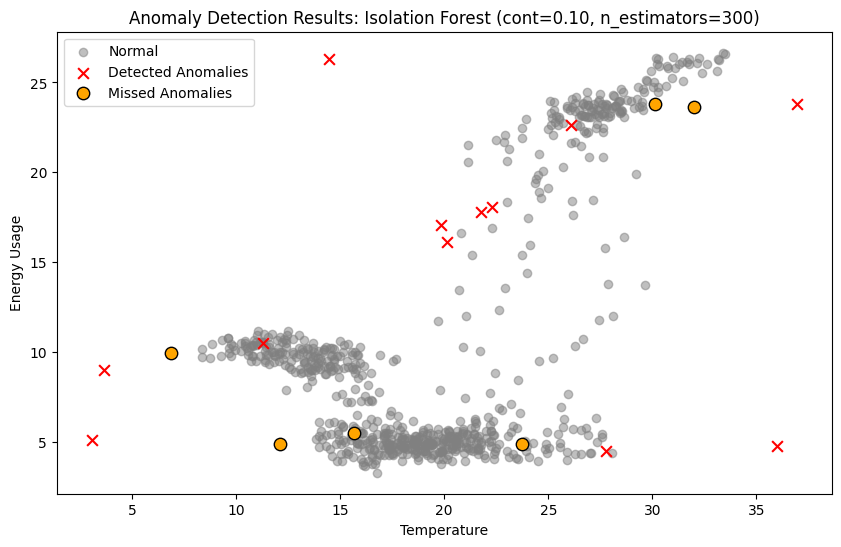

In [6]:
import matplotlib.pyplot as plt

# Calculate predictions again (if not already available)
if_model = IsolationForest(contamination=0.1, n_estimators=300, random_state=42)
if_preds = if_model.fit_predict(df)
y_true = (y_labels == -1)

# Build masks
detected_anomalies = (y_true) & (if_preds == -1)
missed_anomalies = (y_true) & (if_preds != -1)
normal_points = ~y_true

# Plot temperature vs. energy usage
plt.figure(figsize=(10,6))
plt.scatter(df.loc[normal_points, 'temperature'], df.loc[normal_points, 'energy_usage'], 
            c='grey', label='Normal', alpha=0.5)
plt.scatter(df.loc[detected_anomalies, 'temperature'], df.loc[detected_anomalies, 'energy_usage'], 
            c='red', label='Detected Anomalies', marker='x', s=60)
plt.scatter(df.loc[missed_anomalies, 'temperature'], df.loc[missed_anomalies, 'energy_usage'], 
            c='orange', label='Missed Anomalies', marker='o', edgecolors='black', s=80)
plt.xlabel('Temperature')
plt.ylabel('Energy Usage')
plt.legend()
plt.title('Anomaly Detection Results: Isolation Forest (cont=0.10, n_estimators=300)')
plt.show()


# Part 2: Neural Networks

## a)

In [7]:
import pandas as pd
import numpy as np

# Load data
train_data = pd.read_csv('SeaSynTrain.csv')
test_data = pd.read_csv('SeaSynTest.csv')

x_train = train_data[['attrib1', 'attrib2', 'attrib3']].values
y_train = train_data['class'].values

x_test = test_data[['attrib1', 'attrib2', 'attrib3']].values
y_test = test_data['class'].values

# Perceptron function
def train_perceptron(x, y, epochs, learning_rate=0.01):
    weights = np.zeros(x.shape[1] + 1)  # +1 for bias
    for epoch in range(epochs):
        for xi, target in zip(x, y):
            update = learning_rate * (target - predict(xi, weights))
            weights[1:] += update * xi
            weights[0] += update  # bias
    return weights

def predict(xi, weights):
    return int(np.dot(xi, weights[1:]) + weights[0] >= 0)

def evaluate_accuracy(x, y, weights):
    predictions = [predict(xi, weights) for xi in x]
    return np.mean(predictions == y)

# Epoch settings
epoch_list = [1, 5, 10, 15, 20, 50, 60, 80, 100, 120, 150, 200]
results = []

for epochs in epoch_list:
    weights = train_perceptron(x_train, y_train, epochs)
    acc = evaluate_accuracy(x_test, y_test, weights)
    results.append((epochs, acc))

# Create result table
result_df = pd.DataFrame(results, columns=['Epoch', 'Accuracy'])
result_df['Model'] = result_df['Epoch'].apply(lambda e: f'Perceptron ({e})')
result_df = result_df[['Model', 'Accuracy']]

print(result_df.to_string(index=False))


           Model  Accuracy
  Perceptron (1)     0.625
  Perceptron (5)     0.700
 Perceptron (10)     0.600
 Perceptron (15)     0.850
 Perceptron (20)     0.625
 Perceptron (50)     0.650
 Perceptron (60)     0.600
 Perceptron (80)     0.625
Perceptron (100)     0.625
Perceptron (120)     0.675
Perceptron (150)     0.750
Perceptron (200)     0.750


As the number of epochs increases, accuracy improves at first but then levels off, showing little gain after about 100–150 epochs. More epochs beyond this point bring limited extra improvement.

## b)

In [8]:
import pandas as pd
import numpy as np

# Load new data
train_data = pd.read_csv('RingSynTrain.csv')
test_data = pd.read_csv('RingSynTest.csv')

x_train = train_data[['feature1', 'feature2']].values
y_train = train_data['class'].values

x_test = test_data[['feature1', 'feature2']].values
y_test = test_data['class'].values

# Perceptron function (reuse from part a)
def train_perceptron(x, y, epochs, learning_rate=0.01):
    weights = np.zeros(x.shape[1] + 1)  # +1 for bias
    for epoch in range(epochs):
        for xi, target in zip(x, y):
            update = learning_rate * (target - predict(xi, weights))
            weights[1:] += update * xi
            weights[0] += update  # bias
    return weights

def predict(xi, weights):
    return int(np.dot(xi, weights[1:]) + weights[0] >= 0)

def evaluate_accuracy(x, y, weights):
    predictions = [predict(xi, weights) for xi in x]
    return np.mean(predictions == y)

# Epoch settings
epoch_list = [1, 5, 10, 15, 20, 50, 60, 80, 100, 120, 150, 200]
results = []

for epochs in epoch_list:
    weights = train_perceptron(x_train, y_train, epochs)
    acc = evaluate_accuracy(x_test, y_test, weights)
    results.append((epochs, acc))

# Create result table
result_df = pd.DataFrame(results, columns=['Epoch', 'Accuracy'])
result_df['Model'] = result_df['Epoch'].apply(lambda e: f'Perceptron ({e})')
result_df = result_df[['Model', 'Accuracy']]

print(result_df.to_string(index=False))


           Model  Accuracy
  Perceptron (1)  0.656667
  Perceptron (5)  0.656667
 Perceptron (10)  0.720000
 Perceptron (15)  0.656667
 Perceptron (20)  0.656667
 Perceptron (50)  0.750000
 Perceptron (60)  0.656667
 Perceptron (80)  0.656667
Perceptron (100)  0.656667
Perceptron (120)  0.656667
Perceptron (150)  0.656667
Perceptron (200)  0.656667


The perceptron struggles on this non-linearly separable dataset, with accuracy mostly staying around ~66%. Even increasing the number of epochs does not help much because a linear model cannot capture the circular class boundary.